In [2]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import descartes
from shapely.geometry import Point, Polygon


In [2]:
indonesia = gpd.read_file("data/indonesia_boundary.json")
concessions = gpd.read_file("data/Managed_Forest_Concessions_(WRI).geojson")
grid = pd.read_csv("data/land_features_cells.csv")

years = [i[-2:] for i in concessions['legal_term']]
concessions["year"] = ["19"+i  if int(i) > 30 else "20"+i for i in years]

# mock data
# concessions = gpd.read_file("mock/mock_concessions.geojson")
# grid = pd.read_csv("mock/mock_grid.csv")

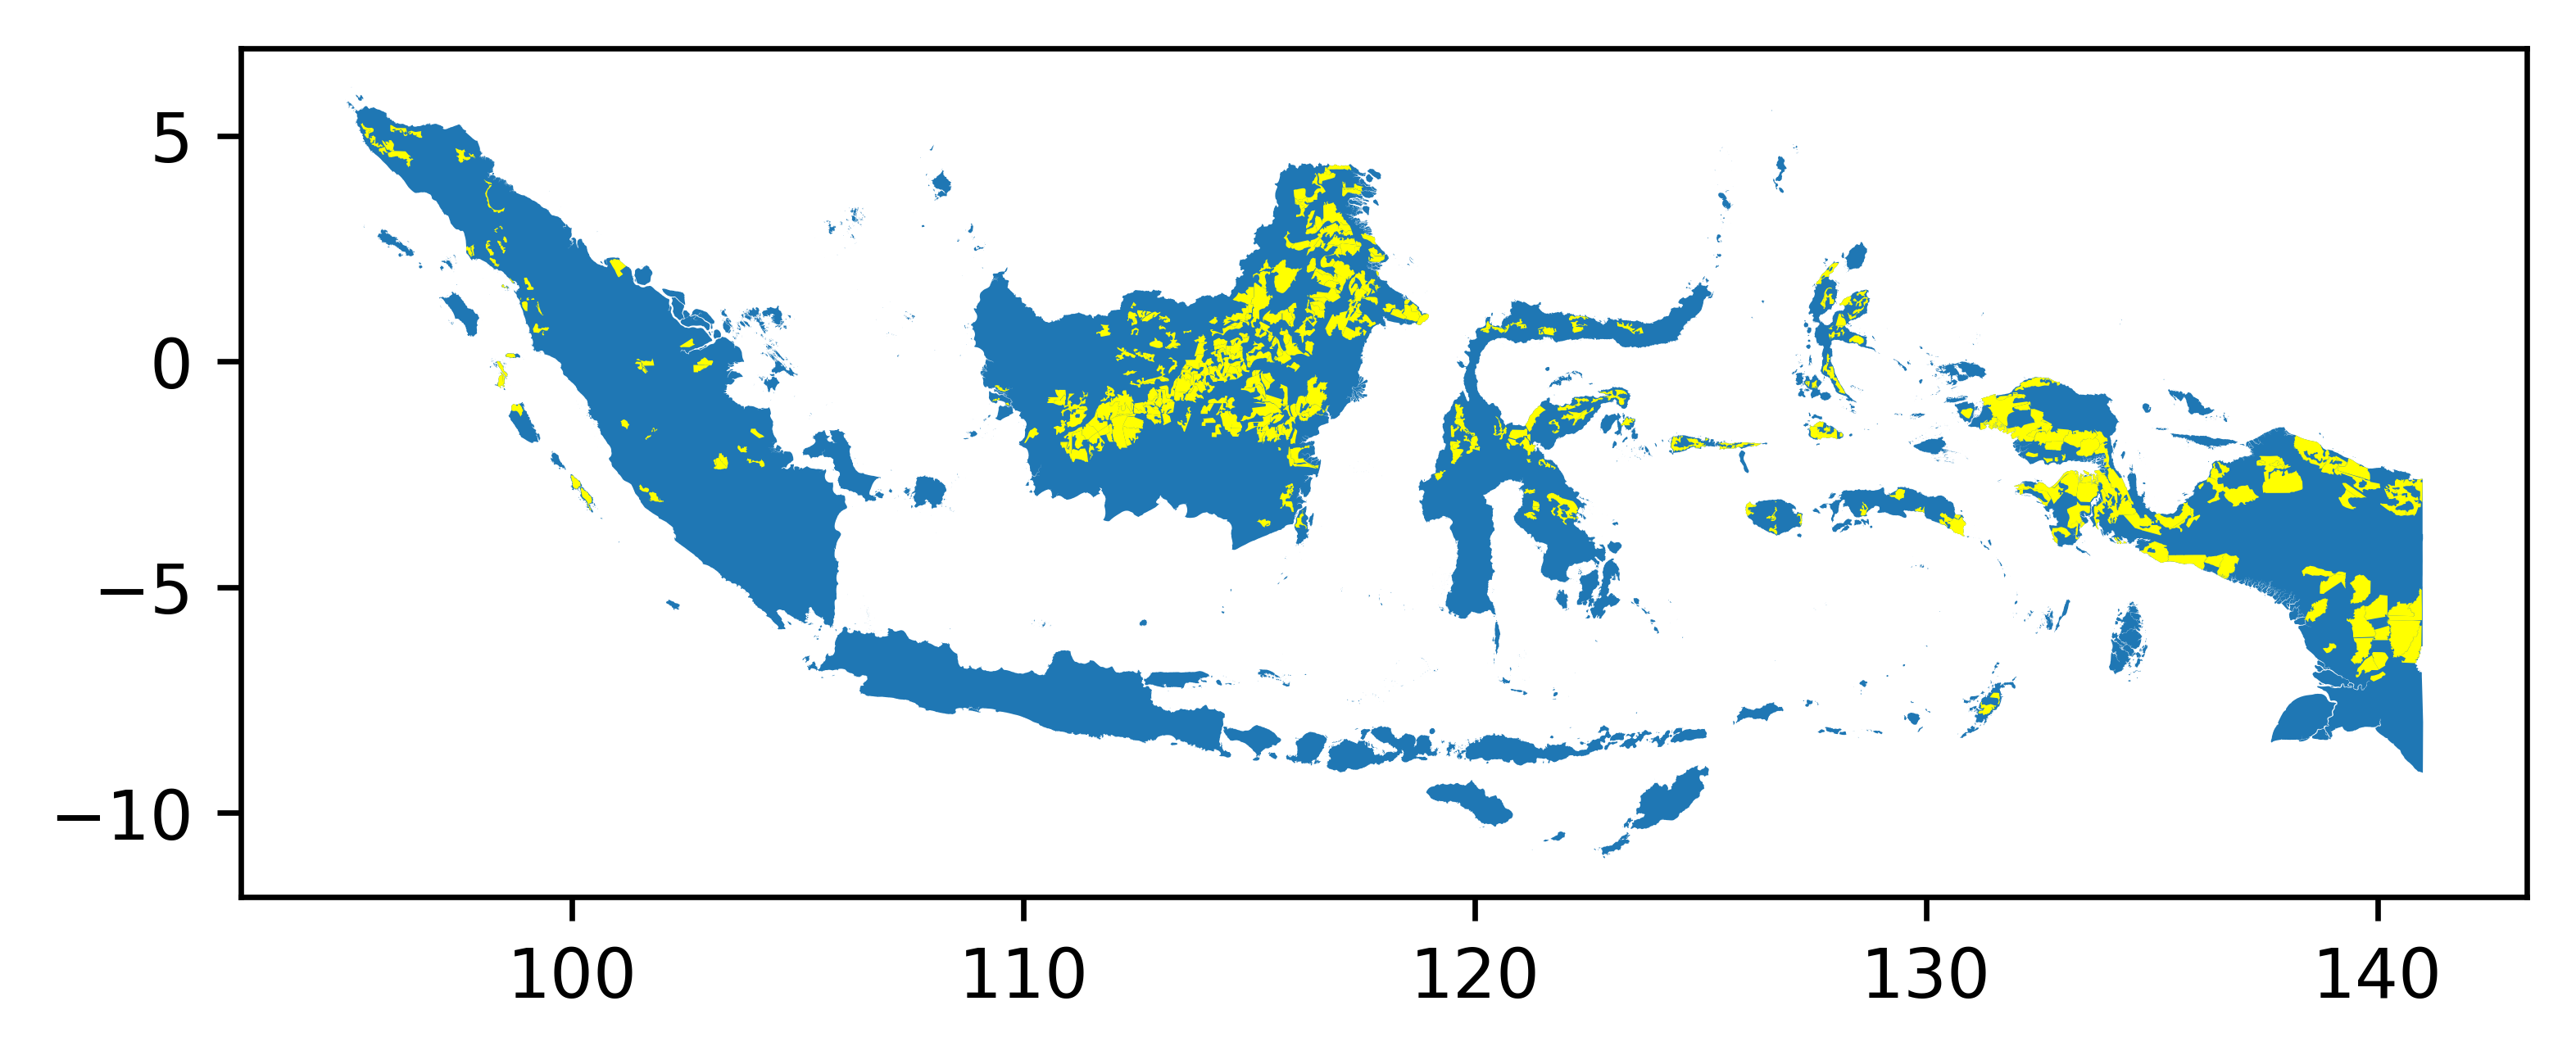

In [3]:
mpl.rcParams['figure.dpi'] = 600 # set dpi
fig = plt.figure()
ax = plt.subplot(111)

indonesia.plot(ax=ax)
concessions.plot(color="yellow", ax=ax)

# grid.plot.scatter(x='geo_x', y='geo_y', s=4, ax=ax, color="red")
plt.axis('scaled')

# concessions['coords'] = concessions['geometry'].apply(lambda x: x.representative_point().coords[:])
# concessions['coords'] = [coords[0] for coords in concessions['coords']]
# for idx, row in concessions.iterrows():
#     plt.annotate(text=concessions.index[idx], xy=row['coords'],
#                  horizontalalignment='center', fontsize=1.5)

# concessions.plot()

# # label grid
# for idx, row in grid.iterrows():
#     plt.annotate(text=grid['id'][idx], xy=(row['geo_x'], row['geo_y']),
#                  horizontalalignment='center', fontsize=15)

plt.show()


In [4]:
# conversions: https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance#:~:text=The%20approximate%20conversions%20are%3A,111.320*cos(latitude)%20km
# geo_x	longitude; higher is eastward
# geo_y	latitude; higher is northward
# 3 km longitutde = 3 / (111.320*cos(latitude)) deg
# 3 km latitude = 3 / 110.574 deg

coords = [] # Point object of given geo_x, geo_y
cell_bounds = [] # Polygon of cell bounds using coord as center
for i in range(len(grid)):
    x, y = grid['geo_x'][i], grid['geo_y'][i]
    dx, dy = 3/(111.320*np.cos(np.deg2rad(y))), 3/110.574
    # dx, dy = 2, 2

    coords.append(Point(x, y))    
    cell_bounds.append(Polygon([(x-dx/2, y-dy/2), (x-dx/2, y+dy/2), (x+dx/2, y+dy/2), (x+dx/2, y-dy/2)]))

grid['coord'] = coords
grid['cell_bounds'] = cell_bounds
grid.head()

,id,cellcode,geo_x,geo_y,area,slope,elev,distroad,distcapital,biomasscarbonruesch,...,defor2002,defor2003,defor2004,defor2005,defor2006,defor2007,defor2008,defor2009,coord,cell_bounds
0,1,100001,111.1630,-8.2789,476.0,7.88374,141.1430,7.62500,90.1111,74.7,...,0.00,0.18,0.00,2.52,0.18,2.34,0.00,0.09,POINT (111.163 -8.2789),POLYGON ((111.1493834325356 -8.292465575994356...
1,2,100004,111.0193,-8.2518,530.0,4.55512,95.0417,5.00000,76.4167,30.0,...,1.08,0.45,0.00,1.17,0.00,2.34,0.90,1.71,POINT (111.0193 -8.251799999999999),POLYGON ((111.0056843680819 -8.265365575994355...
2,3,100005,111.0465,-8.2518,480.0,5.06259,150.3750,2.27778,78.7222,77.0,...,2.52,0.36,0.18,2.25,0.09,1.35,1.35,0.00,POINT (111.0465 -8.251799999999999),POLYGON ((111.0328843680819 -8.265365575994355...
3,4,100006,111.0737,-8.2518,179.0,2.85966,135.2860,1.00000,81.1111,37.3,...,0.09,0.09,1.08,0.00,0.00,0.00,0.27,0.09,POINT (111.0737 -8.251799999999999),POLYGON ((111.0600843680819 -8.265365575994355...
4,5,100008,111.1282,-8.2518,797.0,10.38430,200.3530,4.90323,85.8889,169.0,...,0.27,0.72,0.27,2.43,0.27,1.71,0.36,1.08,POINT (111.1282 -8.251799999999999),POLYGON ((111.1145843680819 -8.265365575994355...


In [5]:
grid.rename(columns={' defor2000 ': 'defor2000'}, inplace=True)


In [6]:
# populate concessions_with_grid and pts_inside_conc
# brute force until coming up with smarter way....problem is the grid is so irregular....
# thought about using nearest neighbors + minimum bounding boxes and structures for that but the grid is just hard to work with in an organized way...
concession_cells = set()
cells_per_concession = [[] for i in range(len(concessions))] # each list contains the index of the cells which are contained in it
cells_proportions_per_concession = [[] for i in range(len(concessions))] # each list contains the proportion of the area covered by the contained cells in the concession
cells_areas_per_concession =  [[] for i in range(len(concessions))] # each list contains the area covered by the contained cells in the concession
for i in range(len(grid)):
    cell = grid['cell_bounds'][i] # Polygon
    j = 0
    for concession in concessions['geometry']:
        if concession.intersects(cell):
            # calculate intersection & proportion 
            intersection = cell.intersection(concession).area
            if intersection > 0:
                concession_cells.add(i)
                cells_per_concession[j].append(i)
                cells_areas_per_concession[j].append(intersection)
                cells_proportions_per_concession[j].append(intersection / cell.area)
        j += 1

In [7]:
print(len(concession_cells))

38688


In [8]:
# print(cells_per_concession)
# print(cells_areas_per_concession)
# print(cells_proportions_per_concession)

In [7]:
total_area_per_concession_from_cell = np.array([sum(ls) for ls in cells_areas_per_concession])
total_area_per_concession_from_shape = np.array([shape.area for shape in concessions['geometry']])
cells_vs_shape_areas = total_area_per_concession_from_cell/total_area_per_concession_from_shape
insufficient_data_25 = [i for i in range(len(cells_vs_shape_areas)) if cells_vs_shape_areas[i] < .25]
insufficient_data_50 = [i for i in range(len(cells_vs_shape_areas)) if cells_vs_shape_areas[i] > .25 and cells_vs_shape_areas[i] < .5]

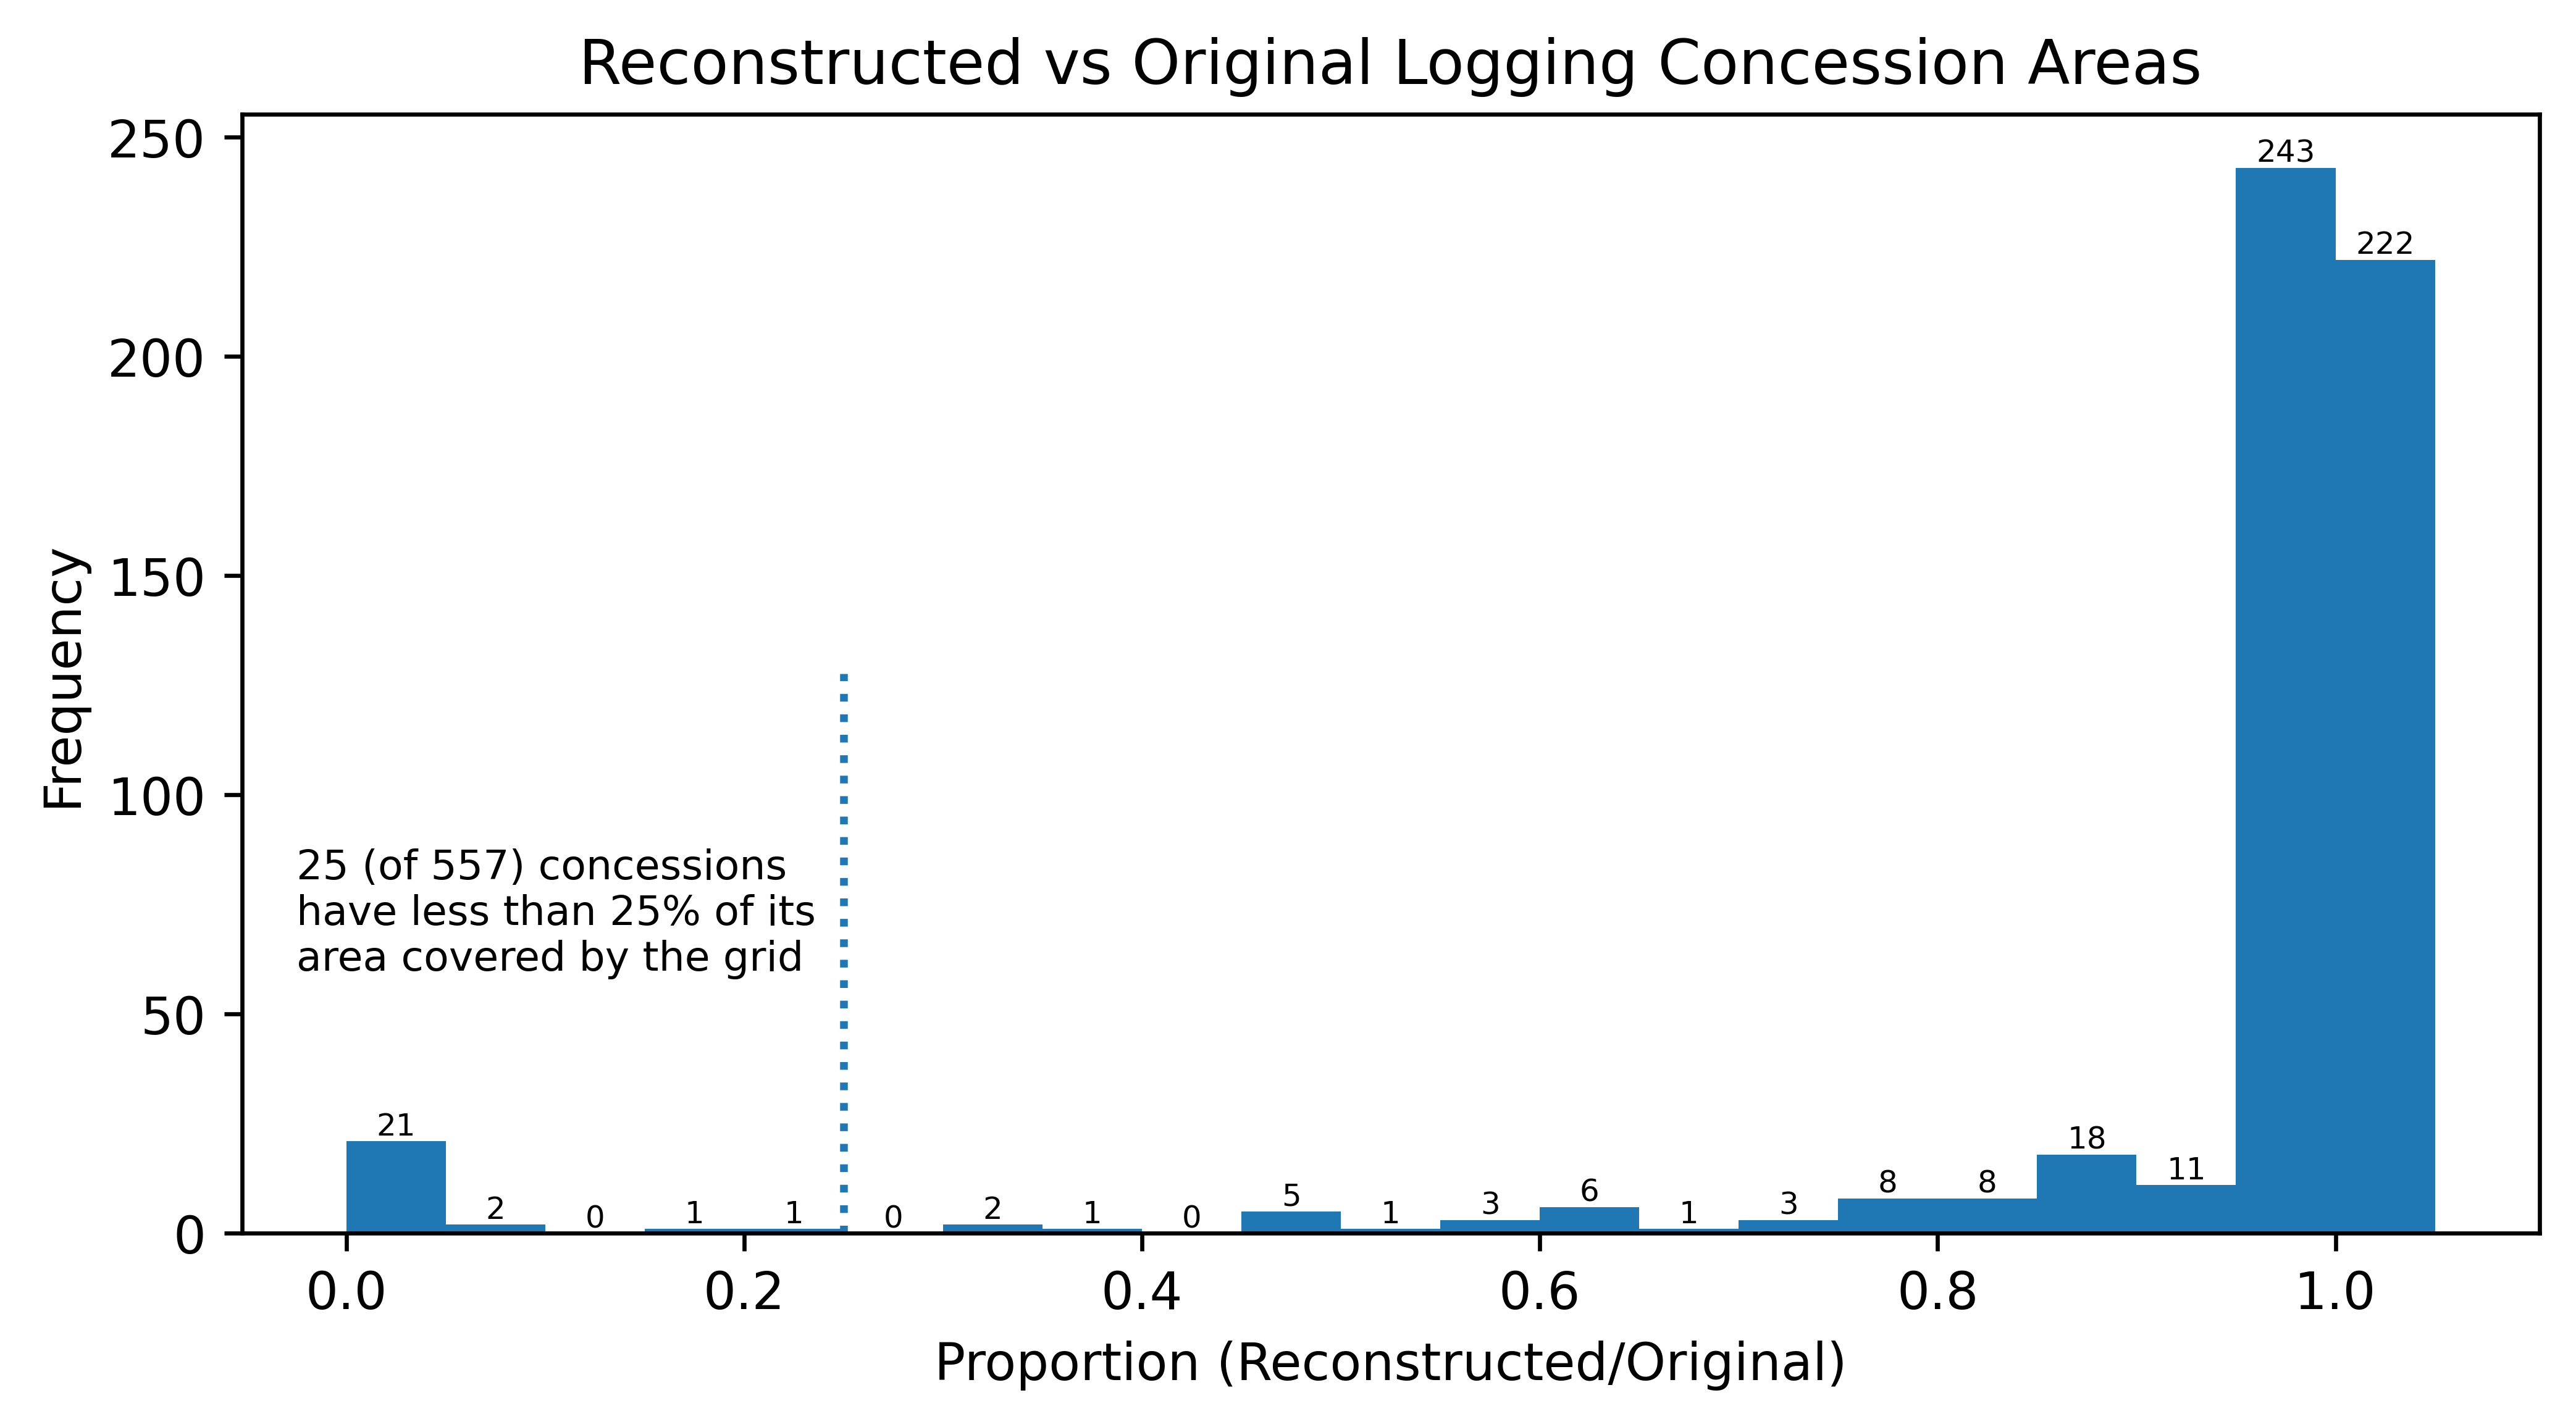

In [8]:
fig, ax = plt.subplots(figsize = (8,4))

plt.hist(cells_vs_shape_areas, bins=np.arange(0, 1.1, .05))
for c in ax.containers:
    ax.bar_label(c, size=6)
ax.axvline(.25, ymax = .5, linestyle = ":")
plt.title("Reconstructed vs Original Logging Concession Areas")
plt.xlabel("Proportion (Reconstructed/Original)")
plt.ylabel("Frequency")
plt.text(s = "25 (of 557) concessions \nhave less than 25% of its \narea covered by the grid", x=-.025, y=60, size=8)
plt.show()

In [9]:
# populate all data per concession

fields = ['id', 'area', 'year', 'slope','elev', 'distroad', 'distcapital', 'peatdepth', 'biomasscarbonruesch', 'soilcarbon', 'biomasscarbonbaccini', 
    'defor2000', 'defor2001','defor2002','defor2003','defor2004','defor2005','defor2006', 'defor2007','defor2008','defor2009']#,
    # 'slope_std', 'elev_std', 'distroad_std', 'distcapital_std', 'biomasscarbonruesch_std', 'soilcarbon_std', 'peatdepth_std', 'biomasscarbonbaccini_std']
fields_dict = {key:[] for key in fields}
num_concessions = len(concessions)


# plain avg
def average_by_cell(key):
    """
    in-place modification/population of fields_dict
    for keys: slope, elev, distroad, distcapital, peatdepth
    """
    for i in range(num_concessions):
        if i in insufficient_data_25:
            fields_dict[key].append(float("NaN"))
        else:
            # print(i)
            cells_contained = cells_per_concession[i]
            # print([grid.iloc[cell, :][key] for cell in cells_contained])
            fields_dict[key].append(np.average([grid.iloc[cell, :][key] for cell in cells_contained]))
            # print(fields_dict[key][-1])

        # do std dev
        # fields_dict[key+"_std"].append(np.std([grid.iloc[cell][key] for cell in cells_contained]))

# area based avg
def average_by_cell_areas(key):
    """
    in-place modification/population of fields_dict
    for keys: biomasscarbonruesch, biomasscarbonbaccini, soilcarbon
    """
    for i in range(num_concessions):
        if i in insufficient_data_25:
            fields_dict[key].append(float("NaN"))
        else:
            cells_contained = cells_per_concession[i]
            areas = cells_areas_per_concession[i]
            proportions = cells_proportions_per_concession[i]
            # print("prop", proportions)
            # print("cell", list(grid.iloc[cells_contained, :][key]))

            proportional_qtys = []
            # total_area = concessions['area'][i] # given
            total_area = sum(areas) # calculuated - should be equiv to ^ 
            for i in range(len(cells_contained)):
                proportional_qtys.append(proportions[i] * grid.iloc[cells_contained[i], :][key])
            # print("qtys", proportional_qtys)
            # print(sum(proportional_qtys), total_area)

            fields_dict[key].append(sum(proportional_qtys)/total_area)

            
        # do std dev (just using attributes from all intersecting cells)
        # fields_dict[key+"_std"].append(np.std([grid.iloc[cell][key] for cell in cells_contained]))

# summing, also doing interpolation
def sum_by_cell_areas(key):
    """
    in-place modification/population of fields_dict
    for keys: all defor200X
    """
    for i in range(num_concessions):
        if i in insufficient_data_25:
            fields_dict[key].append(float("NaN"))
        else:
            cells_contained = cells_per_concession[i]
            areas = cells_areas_per_concession[i]
            proportions = cells_proportions_per_concession[i]
            # print("prop", proportions)
            # print("cell", list(grid.iloc[cells_contained, :][key]))

            proportional_qtys = []
            given_area = concessions['geometry'][i].area # given
            recon_area = sum(areas) # reconstructed/calculuated area - should be (close to) equiv to ^ 
            for i in range(len(cells_contained)):
                proportional_qtys.append(proportions[i] * grid.iloc[cells_contained[i], :][key])
            # print("qtys", proportional_qtys)
            # print(sum(proportional_qtys), total_area)

            # do area corrrection
            total = sum(proportional_qtys) / recon_area * given_area

            fields_dict[key].append(total)

# populate fields
fields_dict['id'] = [i for i in range(1, num_concessions+1)]
fields_dict['area'] = [concessions['area_ha'][i] for i in range(num_concessions)]
fields_dict['year'] = [concessions['year'][i] for i in range(num_concessions)]

for field in fields[3:8]:
    # 'slope','elev', 'distroad', 'distcapital', 'peatdepth'
    print("averaging FIELD:", field)
    average_by_cell(field)

for field in fields[8:11]:
    # 'biomasscarbonruesch', 'soilcarbon', 'biomasscarbonbaccini'
    print("averaging by area FIELD:", field)
    average_by_cell_areas(field)

for field in fields[11:21]:
    # 'defor2000', 'defor2001','defor2002','defor2003','defor2004','defor2005','defor2006', 'defor2007','defor2008','defor2009'
    print("summing FIELD:", field)
    sum_by_cell_areas(field)



averaging FIELD: slope
averaging FIELD: elev
averaging FIELD: distroad
averaging FIELD: distcapital
averaging FIELD: peatdepth
averaging by area FIELD: biomasscarbonruesch
averaging by area FIELD: soilcarbon
averaging by area FIELD: biomasscarbonbaccini
summing FIELD: defor2000
summing FIELD: defor2001
summing FIELD: defor2002
summing FIELD: defor2003
summing FIELD: defor2004
summing FIELD: defor2005
summing FIELD: defor2006
summing FIELD: defor2007
summing FIELD: defor2008
summing FIELD: defor2009


In [12]:
fields_dict['area']

['25677',
 '47812',
 '94835',
 '261827',
 '53587',
 '14555',
 '43884',
 '80097',
 '33093',
 '97893',
 '67396',
 '51223',
 '27732',
 '8194',
 '45818',
 '5379',
 '52749',
 '215691',
 '39976',
 '35906',
 '107096',
 '40637',
 '262868',
 '259332',
 '17806',
 '37581',
 '6857',
 '86481',
 '95289',
 '15297',
 '55788',
 '43346',
 '32699',
 '56800',
 '23139',
 '56302',
 '79407',
 '90554',
 '39629',
 '19773',
 '60894',
 '52620',
 '50032',
 '144684',
 '48976',
 '47077',
 '45568',
 '35009',
 '73444',
 '181465',
 '59267',
 '42476',
 '79396',
 '19823',
 '112119',
 '72563',
 '41746',
 '42333',
 '120423',
 '107427',
 '27187',
 '47565',
 '57494',
 '51833',
 '29174',
 '51148',
 '90296',
 '41779',
 '52067',
 '219603',
 '114756',
 '39558',
 '18403',
 '19722',
 '45858',
 '0',
 '5036',
 '97368',
 '88512',
 '101263',
 '19563',
 '13782',
 '7',
 '54923',
 '24882',
 '32',
 '262',
 '11163',
 '11249',
 '39376',
 '35719',
 '2',
 '13',
 '2',
 '4',
 '1320',
 '92236',
 '40978',
 '92445',
 '41779',
 '4223',
 '91806',
 

In [10]:
# do proportions
for field in fields[11:21]:
    print("FIELD: prop", field)
    # print(fields_dict[field][i],fields_dict['area'][i])

    fields_dict[field+"prop"] = []
    for i in range(len(fields_dict[field])): # for every concession
        if float(fields_dict['area'][i]) == 0: # NaN if concession area is 0 
            fields_dict[field+"prop"].append( float("NaN") )
        else: # take proportion = value/area
            fields_dict[field+"prop"].append( fields_dict[field][i] / float(fields_dict['area'][i]) )
    print(len(fields_dict[field+"prop"])) # sanity check


fields_dict["num_cells"] = [len(ls) for ls in cells_per_concession]




FIELD: prop defor2000
557
FIELD: prop defor2001
557
FIELD: prop defor2002
557
FIELD: prop defor2003
557
FIELD: prop defor2004
557
FIELD: prop defor2005
557
FIELD: prop defor2006
557
FIELD: prop defor2007
557
FIELD: prop defor2008
557
FIELD: prop defor2009
557


In [11]:
# cumulative and avg cumul deforestation up to 2009
# calculated by summing from the year the concession was introduced through 2009
# do proportions
fields_dict['defor_cumul'] = []
fields_dict['defor_cumul_avg'] = []
for i in range(len(fields_dict['defor2000'])):
    # print(i)
    conc_year = fields_dict['year'][i]
    # print(conc_year)
    cumul_defor = sum([fields_dict[field][i] for field in fields[11:21] if int(field[-4:]) >= int(conc_year)])
    fields_dict['defor_cumul'].append(cumul_defor)

# cumulative proportion of deforestation - make this a proportion
fields_dict['defor_cumul_prop'] = [fields_dict['defor_cumul'][i]/float(fields_dict['area'][i]) if float(fields_dict['area'][i]) > 0 else np.NaN for i in range(len(fields_dict['defor_cumul']))]

# [f(x) if condition else g(x) for x in sequence]

    

In [12]:
# cumulative and avg cumul deforestation up to 2009
# calculated by summing from the year the concession was introduced through 2009
# do proportions
fields_dict['defor_cumul_avg'] = []
for i in range(len(fields_dict['defor2000'])):
    # print(i)
    conc_year = fields_dict['year'][i]
    # print(conc_year)
    cumul_defor_avg = np.mean([fields_dict[field][i] for field in fields[11:21] if int(field[-4:]) >= int(conc_year)])
    fields_dict['defor_cumul_avg'].append(cumul_defor_avg)

# cumulative proportion of deforestation - make this a proportion
fields_dict['defor_cumul_prop_avg'] = [fields_dict['defor_cumul_avg'][i]/float(fields_dict['area'][i]) if float(fields_dict['area'][i]) > 0 else np.NaN for i in range(len(fields_dict['defor_cumul_avg']))]

# [f(x) if condition else g(x) for x in sequence]

    

c:\Users\szhan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\szhan\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
for i, field in enumerate(fields_dict):
    if i > 10:
        print (i, field)

11 defor2000
12 defor2001
13 defor2002
14 defor2003
15 defor2004
16 defor2005
17 defor2006
18 defor2007
19 defor2008
20 defor2009
21 defor2000prop
22 defor2001prop
23 defor2002prop
24 defor2003prop
25 defor2004prop
26 defor2005prop
27 defor2006prop
28 defor2007prop
29 defor2008prop
30 defor2009prop
31 num_cells
32 defor_cumul
33 defor_cumul_avg
34 defor_cumul_prop
35 defor_cumul_prop_avg
36 defor2000propover_50p
37 defor2001propover_50p
38 defor2002propover_50p
39 defor2003propover_50p
40 defor2004propover_50p
41 defor2005propover_50p
42 defor2006propover_50p
43 defor2007propover_50p
44 defor2008propover_50p
45 defor2009propover_50p
46 count_over_50p


In [32]:
for field in list(fields_dict.keys())[21:31]:
    print("FIELD:", field)
    median = np.nanmedian(fields_dict[field])
    curr_year = field[5:9]
    # NEED TO FIX THIS
    fields_dict[field+"over_50p"] = [1 if (val >= median and ) else 0 for val in fields_dict[field]]
    # print(len(fields_dict[field+"over_50p"])) # sanity check
# should i do median of all or just median of active concessions

fields_dict["count_over_50p"] = np.array([0 for _ in range(557)])
for i, field in enumerate(fields_dict):
    if i in np.arange(36, 45):
        # print(fields_dict["count_over_50p"])
        print (i, field)
        fields_dict["count_over_50p"] += np.array(fields_dict[field])
        #print(fields_dict["count_over_50p"])

# years the concession is in effect during 2001 and 2009
fields_dict["years_in_effect"] = 2010 - np.array([max(int(yr), 2000) for yr in concessions["year"]])
# standardize the count over the # years the concession was in effect
fields_dict["over_50p_normed"] = np.array(fields_dict["count_over_50p"]) / fields_dict["years_in_effect"]


FIELD: defor2000prop
FIELD: defor2001prop
FIELD: defor2002prop
FIELD: defor2003prop
FIELD: defor2004prop
FIELD: defor2005prop
FIELD: defor2006prop
FIELD: defor2007prop
FIELD: defor2008prop
FIELD: defor2009prop
36 defor2000propover_50p
37 defor2001propover_50p
38 defor2002propover_50p
39 defor2003propover_50p
40 defor2004propover_50p
41 defor2005propover_50p
42 defor2006propover_50p
43 defor2007propover_50p
44 defor2008propover_50p


In [34]:
fields_dict["count_over_50p"]

array([9, 9, 2, 9, 3, 6, 6, 9, 9, 6, 7, 8, 8, 4, 3, 3, 7, 9, 1, 3, 9, 9,
       9, 4, 2, 5, 0, 8, 0, 8, 0, 8, 0, 1, 3, 1, 5, 1, 9, 8, 9, 7, 9, 9,
       9, 9, 9, 8, 9, 8, 8, 7, 8, 9, 7, 2, 4, 3, 9, 9, 9, 9, 9, 9, 9, 8,
       9, 9, 9, 7, 8, 7, 0, 0, 0, 0, 0, 0, 4, 3, 6, 3, 5, 9, 3, 7, 1, 5,
       2, 1, 0, 0, 0, 0, 0, 0, 6, 8, 8, 9, 7, 9, 8, 9, 7, 0, 8, 9, 9, 9,
       9, 5, 3, 9, 3, 3, 7, 6, 0, 2, 9, 0, 0, 1, 3, 1, 1, 6, 0, 8, 8, 8,
       3, 1, 4, 8, 9, 7, 0, 0, 0, 5, 9, 4, 2, 4, 7, 9, 8, 7, 9, 8, 0, 0,
       8, 0, 0, 0, 0, 0, 0, 9, 4, 4, 0, 4, 0, 4, 3, 1, 9, 3, 9, 0, 9, 9,
       9, 8, 1, 0, 6, 8, 0, 4, 6, 9, 4, 3, 9, 9, 2, 8, 9, 8, 0, 7, 0, 8,
       9, 7, 0, 2, 7, 4, 1, 0, 0, 8, 0, 8, 6, 2, 0, 1, 0, 0, 0, 0, 5, 4,
       0, 9, 9, 0, 3, 0, 1, 1, 9, 9, 4, 9, 0, 0, 8, 8, 8, 7, 8, 5, 2, 5,
       6, 0, 5, 9, 6, 3, 4, 7, 5, 9, 9, 9, 9, 1, 0, 0, 1, 0, 0, 6, 3, 1,
       9, 8, 1, 9, 4, 8, 9, 9, 6, 6, 1, 9, 9, 1, 0, 7, 0, 0, 0, 4, 7, 4,
       1, 4, 0, 0, 9, 6, 9, 0, 0, 0, 9, 0, 3, 9, 8,

In [30]:
for i in fields_dict:
    print(i, len(fields_dict[i]))
features_df = pd.DataFrame.from_dict(fields_dict)
features_df

id 557
area 557
year 557
slope 557
elev 557
distroad 557
distcapital 557
peatdepth 557
biomasscarbonruesch 557
soilcarbon 557
biomasscarbonbaccini 557
defor2000 557
defor2001 557
defor2002 557
defor2003 557
defor2004 557
defor2005 557
defor2006 557
defor2007 557
defor2008 557
defor2009 557
defor2000prop 557
defor2001prop 557
defor2002prop 557
defor2003prop 557
defor2004prop 557
defor2005prop 557
defor2006prop 557
defor2007prop 557
defor2008prop 557
defor2009prop 557
num_cells 557
defor_cumul 557
defor_cumul_avg 557
defor_cumul_prop 557
defor_cumul_prop_avg 557
defor2000propover_50p 557
defor2001propover_50p 557
defor2002propover_50p 557
defor2003propover_50p 557
defor2004propover_50p 557
defor2005propover_50p 557
defor2006propover_50p 557
defor2007propover_50p 557
defor2008propover_50p 557
defor2009propover_50p 557
count_over_50p 557
over_50p_normed 557
years_in_effect 557


,id,area,year,slope,elev,distroad,distcapital,peatdepth,biomasscarbonruesch,soilcarbon,...,defor2003propover_50p,defor2004propover_50p,defor2005propover_50p,defor2006propover_50p,defor2007propover_50p,defor2008propover_50p,defor2009propover_50p,count_over_50p,over_50p_normed,years_in_effect
0,1,25677,2009,5.703810,136.713525,78.973377,188.636000,0.0,288831.136720,61542.313333,...,1,1,1,1,1,1,1,9,9.0,1
1,2,47812,2009,5.481341,143.491448,128.181840,162.474440,0.0,272221.832142,61539.484544,...,1,1,1,1,1,1,1,9,9.0,1
2,3,94835,2008,7.100132,369.296201,13.425867,280.545799,0.0,307651.118975,61544.352106,...,0,0,0,1,0,0,0,2,1.0,2
3,4,261827,2009,3.185515,98.517925,27.137641,174.347466,0.0,267778.996626,68668.220746,...,1,1,1,1,1,1,1,9,9.0,1
4,5,53587,2008,8.018633,431.265148,15.181501,249.199159,0.0,301675.907935,61545.272414,...,0,1,0,1,1,0,0,3,1.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,553,6043,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,1
553,554,12340,2009,12.754385,528.159760,156.620120,245.317720,0.0,306831.090046,92354.434063,...,1,1,0,0,0,0,0,2,2.0,1
554,555,49459,2009,11.012047,306.129807,162.870260,243.175411,0.0,292592.035444,89097.703384,...,1,1,1,1,1,1,1,9,9.0,1
555,556,31252,2009,14.942977,351.004888,48.895012,403.195735,0.0,302653.468888,60696.087878,...,0,0,1,0,0,1,0,4,4.0,1


In [21]:
# import adjacency matrix
# adj_mat = np.array(pd.read_csv("outputs/logging_concession_adjacencies_no_buffer.csv", header=None))
adj_mat = pd.read_csv("outputs/logging_concession_adjacencies_no_buffer.csv", header=None)

# print(adj_df.shape)


In [22]:
features_df.columns

Index(['id', 'area', 'year', 'slope', 'elev', 'distroad', 'distcapital',
       'peatdepth', 'biomasscarbonruesch', 'soilcarbon',
       'biomasscarbonbaccini', 'defor2000', 'defor2001', 'defor2002',
       'defor2003', 'defor2004', 'defor2005', 'defor2006', 'defor2007',
       'defor2008', 'defor2009', 'defor2000prop', 'defor2001prop',
       'defor2002prop', 'defor2003prop', 'defor2004prop', 'defor2005prop',
       'defor2006prop', 'defor2007prop', 'defor2008prop', 'defor2009prop',
       'num_cells', 'defor_cumul', 'defor_cumul_avg', 'defor_cumul_prop',
       'defor_cumul_prop_avg', 'defor2000propover_50p',
       'defor2001propover_50p', 'defor2002propover_50p',
       'defor2003propover_50p', 'defor2004propover_50p',
       'defor2005propover_50p', 'defor2006propover_50p',
       'defor2007propover_50p', 'defor2008propover_50p',
       'defor2009propover_50p', 'count_over_50p', 'over_50p_normed',
       'years_in_effect'],
      dtype='object')

In [24]:
features_df["degree"] = [sum(adj_mat.iloc[i, :]) for i in range(len(adj_mat))]
features_df.to_csv("outputs/features_by_logging_concession.csv", index=False)


In [7]:
features_df = (pd.read_csv("outputs/features_by_logging_concession.csv"))


In [8]:
type(features_df['year'][80])

numpy.int64

In [54]:
# make exis column vectors: 1 if present in year i, 0 if not
exis = np.array([(np.array(features_df['year']) <= yr).astype(int) for yr in range(2000,2010)])
defor = np.array([features_df["defor"+str(yr)+"prop"] for yr in range(2000,2010)])
conc_defor = exis * defor

medians = []
for arr in conc_defor:
    arr = np.nan_to_num(arr, copy=False, nan=0) 
    arr = arr[arr != 0] # remove 0s
    medians.append(np.median(arr))
medians = np.array(medians)
    
high_defor_indic = np.array([(conc_defor[i] >= medians[i]).astype(int) for i in range(10)])
sum_exis = np.sum(exis, 0)
sum_high_defor_indic = np.sum(high_defor_indic, 0)
#print(sum_exis)
#print(sum_high_defor_indic)
normed_high_defor_indic = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)
print(normed_high_defor_indic)



[1.         1.         0.         1.         0.         0.66666667
 0.75       1.         1.         0.44444444 0.75       0.75
 0.88888889 1.         0.         0.         1.         1.
 0.         0.22222222 1.         1.         1.         0.5
 0.         1.         0.         1.         0.         0.5
 0.         0.9        0.         0.4        0.25       0.2
 0.5        0.1        1.         0.9        1.         0.66666667
 0.88888889 1.         1.         1.         1.         1.
 0.83333333 0.9        0.9        0.8        1.         1.
 0.6        0.2        0.3        0.22222222 1.         1.
 1.         1.         0.83333333 1.         1.         0.9
 1.         1.         1.         0.83333333 0.8        1.
 0.         0.         0.         0.         0.         0.
 0.4        0.25       0.5        0.3        0.5        1.
 0.25       0.75       0.5        0.75       0.5        0.
 0.         0.         0.         0.         0.         0.
 0.6        0.9        0.7        

C:\Users\szhan\AppData\Local\Temp\ipykernel_27000\1427679924.py:18: RuntimeWarning: invalid value encountered in true_divide
  normed_high_defor_indic = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)


In [13]:

# make exis column vectors: 1 if present in year i, 0 if not
exis = np.array([(np.array(features_df['year']) <= yr).astype(int) for yr in range(2000,2010)])
defor = np.array([features_df["defor"+str(yr)+"prop"] for yr in range(2000,2010)])
conc_defor = exis * defor

medians = []
for arr in conc_defor:
    arr = np.nan_to_num(arr, copy=False, nan=0) 
    arr = arr[arr != 0] # remove 0s
    medians.append(np.median(arr))
medians = np.array(medians)
    
high_defor_indic = np.array([np.maximum(0, conc_defor[i] - medians[i]) for i in range(10)])
sum_exis = np.sum(exis, 0)
sum_high_defor_indic = np.sum(high_defor_indic, 0)
#print(sum_exis)
#print(sum_high_defor_indic)
normed_high_defor_indic_quantitative = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)
print(normed_high_defor_indic)




[3.12059061e-03 1.30777706e-04 0.00000000e+00 8.54306984e-03
 0.00000000e+00 4.44928262e-04 7.79209879e-04 3.23532571e-03
 1.44352291e-02 3.72141579e-04 2.50513880e-03 1.43132090e-03
 4.30779890e-03 1.17964598e-03 0.00000000e+00 0.00000000e+00
 1.66569763e-02 1.70027247e-02 0.00000000e+00 1.43248899e-04
 5.13610853e-03 2.42678333e-03 7.67693423e-03 6.33111505e-04
 0.00000000e+00 1.93582515e-03 0.00000000e+00 1.04739698e-03
 0.00000000e+00 4.73643339e-04 0.00000000e+00 8.61226461e-04
 0.00000000e+00 6.63421051e-04 1.37629439e-04 1.54062690e-04
 1.23494952e-03 2.38774439e-04 2.33681850e-03 3.99642587e-03
 3.79700667e-03 4.52771227e-04 1.80515362e-03 1.42824506e-03
 3.39936687e-03 2.33011281e-03 2.68982277e-03 3.55809541e-03
 1.19244417e-03 1.55824851e-03 2.33649203e-03 5.54564209e-03
 2.43166493e-02 2.88642018e-02 6.47769771e-04 1.01197736e-04
 3.44595337e-04 3.86194873e-05 7.12076412e-03 3.28564964e-02
 3.35528010e-03 3.52378793e-02 1.44473632e-03 2.22936015e-02
 6.95469039e-03 7.567027

C:\Users\szhan\AppData\Local\Temp\ipykernel_22780\3461587802.py:18: RuntimeWarning: invalid value encountered in true_divide
  normed_high_defor_indic_quantitative = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)


In [14]:
features_df['normed_high_defor_indic'] = normed_high_defor_indic
features_df['normed_high_defor_indic_quantitative'] = normed_high_defor_indic_quantitative
features_df.to_csv("outputs/features_by_logging_concession.csv", index=False)


In [210]:
# create panel data
defor_cols = features_df.columns[-10:]
print(defor_cols)

# construct df in panel data format
panel_frames = []
for ind, field in enumerate(defor_cols):
    year = field[-4:]
    # static variables
    year_df = pd.DataFrame(features_df.loc[:,["id", 'area', 'slope', 'elev', 
        'distroad', 'distcapital', 'peatdepth', 'biomasscarbonruesch', 'soilcarbon', 'biomasscarbonbaccini']])
    year_df["year"] = [year for _ in range(len(features_df))]

    # neighbor effect
    year_df["neighboreffect"] = adj_mat.dot(np.array(features_df.loc[:,field]))
    panel_frames.append(year_df)
panel_df = pd.concat(panel_frames)#, ignore_index=True)
panel_df = panel_df.sort_values(by=["id"], axis=0, ascending=True, kind="stable").reset_index(drop=True)
# panel_df

#resort cols s.t. year and year_stat come first
# cols = panel_df.columns.tolist()
# cols = cols[0:1] + cols[-2:] + cols[1:-2]
# panel_df = panel_df[cols]
# panel_df

Index(['defor2000', 'defor2001', 'defor2002', 'defor2003', 'defor2004',
       'defor2005', 'defor2006', 'defor2007', 'defor2008', 'defor2009'],
      dtype='object')


In [211]:
panel_df.to_csv("mock/mock_panel_data.csv", na_rep=0)